In [228]:
import os
import csv
import pandas as pd
import time
import pickle
import sys

In [229]:
print(os.getcwd())
# cwd = os.chdir(os.path.join(os.getcwd(), "logda"))

/local-scratch/localhome/pagand/projects/DaTu/ML/logda


In [230]:
File_xlsx = "data/integration_log_group_a.xlsx"
File_csv = "data/group_a_raw.csv"
df = pd.read_excel(File_xlsx)
df = df.iloc[:, :-1] 

print(df.head())

  username           Date and Time Time since session started\n(h:mm:ss)  \
0       a1 2023-08-03 09:34:57.240                              00:00:00   
1       a1 2023-08-03 09:35:00.152                              00:00:02   
2       a1 2023-08-03 09:35:30.167                              00:00:32   
3       a1 2023-08-03 09:41:32.112                              00:06:34   
4       a1 2023-08-03 09:41:32.112                              00:06:34   

         space                     action  
0          NaN                 User login  
1   /courses/1                  Load page  
2  EDA Toolbox  Load default toolbox page  
3    Problem 1              Start problem  
4    Problem 1               First answer  


In [231]:
# get the unique values of the column action
unique_actions = df.action.unique()
# peint unique actions with their counts
print(df['action'].value_counts())

action
Change answer                      4363
First answer                       2159
Request another hint               1479
Streamlit interaction              1338
Update confidence                  1336
Auto-save log                      1018
New answer explanation              977
Load default toolbox page           942
Request first hint                  914
Paste answer                        646
Update answer explanation           597
Load page                           453
Freeform code run                   441
User request                        400
Chatbot response                    400
Run code                            314
Run code error                      276
Respond to hint feedback            166
Start reading sub-module            135
Start problem                       125
Submit problem                      111
User login                           53
Complete sub-module                  42
Save note                            22
Stop reading sub-module preview  

In [232]:
# since the frequency of different actions are different, Normalize the counts of actions by the total number of actions per user to account for the difference in frequencies.

# create new df where the rows are each user and the columns are the counts of each action from unique_actions
action_counts = pd.DataFrame(columns=unique_actions)
for user in df.username.unique():
    user_actions = df[df.username == user].action.value_counts()
    action_counts.loc[user, user_actions.index] = user_actions.values
action_counts = action_counts.fillna(0)
# add the total_actions column to the action_counts df
action_counts['total'] = df.groupby('username').count().action
flag = 0
action_counts.head()

,User login,Load page,Load default toolbox page,Start problem,First answer,New answer explanation,Update answer explanation,Update confidence,Request first hint,Request another hint,...,Freeform code run,Start reading sub-module,Complete sub-module,Run code error,User request,Chatbot response,Save note,Stop reading sub-module preview,User logout,total
a1,1,4,21,3,41,19,17,60,50,81,...,14,0,0,0,0,0,0,0,0,539
a2,1,22,12,1,11,11,6,11,13,26,...,0,11,5,3,0,0,0,0,0,202
a3,1,1,6,3,38,34,5,30,32,49,...,3,0,0,0,0,0,0,0,0,245
a4,1,37,42,3,76,9,11,16,36,69,...,0,6,1,11,6,6,4,0,0,679
a5,1,5,29,3,60,44,22,48,12,22,...,7,0,0,15,25,25,0,0,0,513


In [233]:
# read the scores
File_score_xlsx = "data/Groupa_scores.xlsx"
read_file = pd.read_excel(File_score_xlsx)

# change the first column name to username
read_file.rename(columns={"Participant ID's":'username', 'Problem 1 (Score out of 16)': 'score1',
                         'Problem 2 (Score out of 20)': 'score2', 'Problem 3 (Score out of 18)': 'score3' }, inplace=True)
read_file[:-3]
# use the username as the index
read_file.set_index('username', inplace=True)
# devide first column by 16, second column by 20, third column by 18
read_file['score1'] = read_file['score1'].div(16)
read_file['score2'] = read_file['score2'].div(20)
read_file['score3'] = read_file['score3'].div(18)

read_file.head()


,score1,score2,score3
username,,,
a1,0.6875,0.45,0.583333
a2,0.4375,0.00,0.000000
a3,0.6250,0.35,0.166667
a4,0.5000,0.45,0.000000
a5,0.4375,0.30,0.194444


In [234]:
# merge the scores with the action_counts df
if not flag:
    action_counts = action_counts.merge(read_file, left_index=True, right_index=True)
flag = 1
action_counts.head()


,User login,Load page,Load default toolbox page,Start problem,First answer,New answer explanation,Update answer explanation,Update confidence,Request first hint,Request another hint,...,Run code error,User request,Chatbot response,Save note,Stop reading sub-module preview,User logout,total,score1,score2,score3
a1,1,4,21,3,41,19,17,60,50,81,...,0,0,0,0,0,0,539,0.6875,0.45,0.583333
a2,1,22,12,1,11,11,6,11,13,26,...,3,0,0,0,0,0,202,0.4375,0.00,0.000000
a3,1,1,6,3,38,34,5,30,32,49,...,0,0,0,0,0,0,245,0.6250,0.35,0.166667
a4,1,37,42,3,76,9,11,16,36,69,...,11,6,6,4,0,0,679,0.5000,0.45,0.000000
a5,1,5,29,3,60,44,22,48,12,22,...,15,25,25,0,0,0,513,0.4375,0.30,0.194444


In [235]:
# create a score colomn by averaging the three scores
action_counts['score'] = action_counts[['score1', 'score2', 'score3']].mean(axis=1)

In [316]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

RMSE:  0.03345456533312649
R2:  0.033577138835764964
RMSE normalize:  0.0254572886678088
R2 normalized:  0.26459944982557004


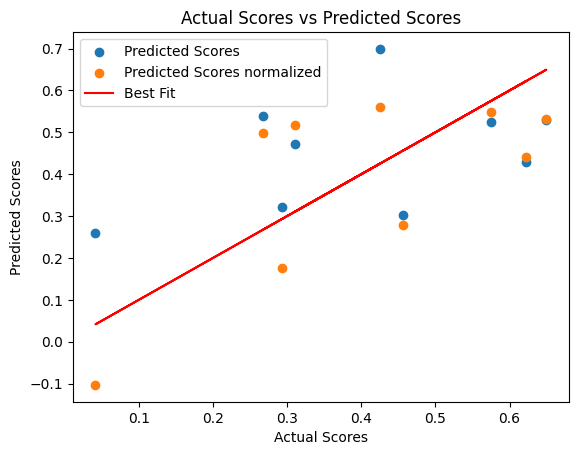

In [174]:


# Split the data into training and testing sets
X = action_counts.drop(['score1', 'score2', 'score3', 'score'], axis=1)
y = action_counts['score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the scores for the test set
y_pred = model.predict(X_test)

# use the total column to normalize the counts of actions
for col in X.columns:
    X[col] = X[col].div(action_counts['total'])
# drop the total column
X = X.drop('total', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the scores for the test set
y_pred_norm = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R2: ', r2)

# Evaluate the model normalized
rmse = mean_squared_error(y_test, y_pred_norm)
r2 = r2_score(y_test, y_pred_norm)
print('RMSE normalize: ', rmse)
print('R2 normalized: ', r2)

# plot the predicted and actual scores
plt.scatter(y_test, y_pred, label='Predicted Scores')
plt.scatter(y_test, y_pred_norm, label='Predicted Scores normalized')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual Scores vs Predicted Scores')
# plot the line of best fit
plt.plot(y_test, y_test, color='red', label='Best Fit')
plt.legend()
plt.show()




In [236]:
# create each problem seperately
#augment a,b group having access to the chatpot or not
# convert to ex AI
# p1,p2,p3 - 
# sequence mining HMM

In [237]:
df = df.fillna('0')
df.iloc[0, 3] = 'Probelm 1'
# change the third column name to time
df.rename(columns={"Time since session started\n(h:mm:ss)":'time'}, inplace=True)
df.head()

,username,Date and Time,time,space,action
0,a1,2023-08-03 09:34:57.240,00:00:00,Probelm 1,User login
1,a1,2023-08-03 09:35:00.152,00:00:02,/courses/1,Load page
2,a1,2023-08-03 09:35:30.167,00:00:32,EDA Toolbox,Load default toolbox page
3,a1,2023-08-03 09:41:32.112,00:06:34,Problem 1,Start problem
4,a1,2023-08-03 09:41:32.112,00:06:34,Problem 1,First answer


In [238]:
# correct the df. If in the space column does not start with 'Problem' then change it with the next row
for i in range(len(df)):
    if df.iloc[i, 3][:7] != 'Problem':
        df.iloc[i, 3] = df.iloc[i-1, 3]

In [239]:
df['space'].value_counts()

space
Problem 1    7870
Problem 2    6157
Problem 3    4700
Name: count, dtype: int64

In [240]:
# let's create a new df where the colomns are the count of actions for each problem plus the problem number, username and the corresponding score
new_df = pd.DataFrame(columns= list(unique_actions)+ [ 'total_actions']+ [p for p in df.space.unique()]+ ['username', 'score']) 
for user in df.username.unique():
    for problem in df.space.unique():
        user_problem = df[(df.username == user) & (df.space == problem)].action.value_counts()
        new_df.loc[len(new_df), user_problem.index] = user_problem.values
        new_df.loc[len(new_df)-1, str(problem)] = 1
        new_df.loc[len(new_df)-1, 'username'] = user
        new_df.loc[len(new_df)-1, 'score'] = action_counts.loc[user, 'score'+str(problem)[-1:]]
        new_df.loc[len(new_df)-1, 'total_actions'] = action_counts.loc[user, 'total']
new_df = new_df.fillna(0)
new_df.head()

,User login,Load page,Load default toolbox page,Start problem,First answer,New answer explanation,Update answer explanation,Update confidence,Request first hint,Request another hint,...,Chatbot response,Save note,Stop reading sub-module preview,User logout,total_actions,Problem 3,Problem 1,Problem 2,username,score
0,1,4,18,1,0,0,0,21,18,36,...,0,0,0,0,539,1,0,0,a1,0.583333
1,0,0,0,1,16,11,14,16,16,26,...,0,0,0,0,539,0,1,0,a1,0.687500
2,0,0,3,1,25,8,3,23,16,19,...,0,0,0,0,539,0,0,1,a1,0.450000
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,202,1,0,0,a2,0.000000
4,0,21,11,1,11,11,6,11,13,26,...,0,0,0,0,202,0,1,0,a2,0.437500


RMSE:  0.035635400904778826
R2:  0.48361061356851676
RMSE normalize:  0.037067072228744315
R2 normalize:  0.4628643932992522


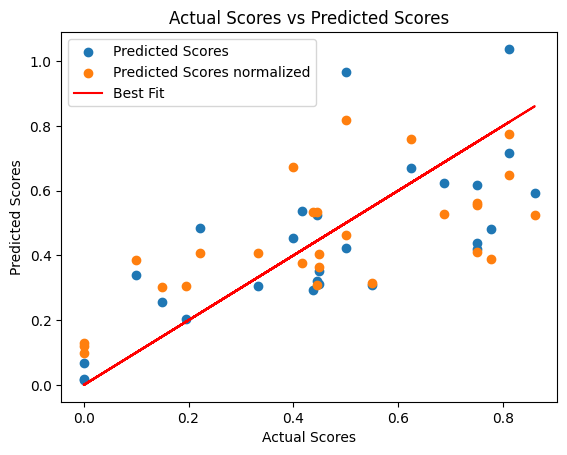

In [241]:
# Split the data into training and testing sets
X = new_df.drop(['username', 'score'], axis=1)
y = new_df['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the scores for the test set
y_pred = model.predict(X_test)

# norrmalize the features
for col in X.columns:
    # X[col] = X[col].div(X[col].sum())
    X[col] = X[col].div(new_df['total_actions'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the scores for the test set
y_pred_norm = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R2: ', r2)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred_norm)
r2 = r2_score(y_test, y_pred_norm)
print('RMSE normalize: ', rmse)
print('R2 normalize: ', r2)


# plot the predicted and actual scores
plt.scatter(y_test, y_pred, label='Predicted Scores')
plt.scatter(y_test, y_pred_norm, label='Predicted Scores normalized')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual Scores vs Predicted Scores')
# plot the line of best fit
plt.plot(y_test, y_test, color='red', label='Best Fit')
plt.legend()
plt.show()



In [242]:
# get insight what features are important
# remove the features that are not important

# Auto-save log                      1018
# Load default toolbox page           942
# Load page                           453
# Run code error                      276
# Chatbot response                    400
# Start reading sub-module            135
# User login                           53
# User logout                           6
# Start problem                       124
# Submit problem                      111

In [243]:
new_df.drop(['Auto-save log', 'Load default toolbox page', 'Load page', 'Run code error', 'Chatbot response', 'Start reading sub-module', 'User login', 'User logout',  'Start problem', 'Submit problem'], axis=1, inplace=True)

RMSE:  0.02608668009692632
R2:  0.621980267170793
RMSE normalize:  0.0401874529536555
R2 normalize:  0.4176472371270754


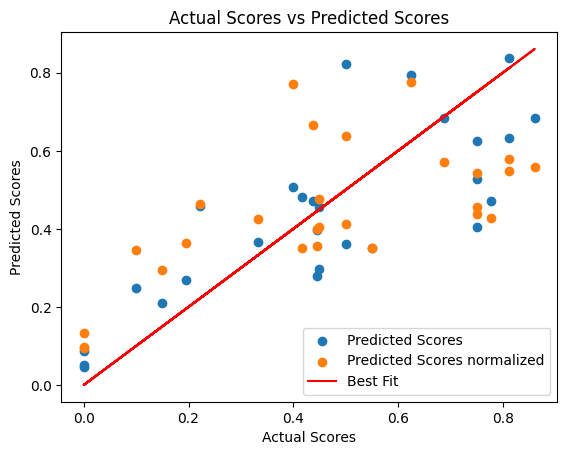

In [244]:
# Split the data into training and testing sets
X = new_df.drop(['username', 'score'], axis=1)
y = new_df['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the scores for the test set
y_pred = model.predict(X_test)

# norrmalize the features
for col in X.columns:
    # X[col] = X[col].div(X[col].sum())
    X[col] = X[col].div(new_df['total_actions'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the scores for the test set
y_pred_norm = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R2: ', r2)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred_norm)
r2 = r2_score(y_test, y_pred_norm)
print('RMSE normalize: ', rmse)
print('R2 normalize: ', r2)


# plot the predicted and actual scores
plt.scatter(y_test, y_pred, label='Predicted Scores')
plt.scatter(y_test, y_pred_norm, label='Predicted Scores normalized')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual Scores vs Predicted Scores')
# plot the line of best fit
plt.plot(y_test, y_test, color='red', label='Best Fit')
plt.legend()
plt.show()



previous length of data:  135
IQR:  0.4166666666666667
current length of data:  135


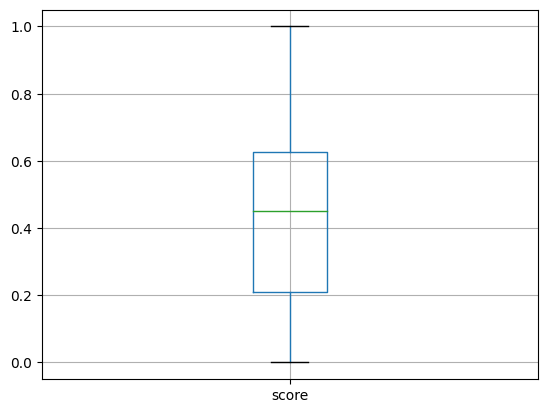

In [245]:
# apply outlier detection with IQR
# remove the outliers in new_df
# find the outliers in score column
Q1 = new_df['score'].quantile(0.25)
Q3 = new_df['score'].quantile(0.75)
IQR = Q3 - Q1
print('previous length of data: ' ,len(new_df))
print("IQR: ", IQR)
# plot the boxplot to see the outliers
new_df.boxplot(column=['score'])

# remove the outliers in score column
new_df = new_df[~((new_df['score'] < (Q1 - 1.5 * IQR)) |(new_df['score'] > (Q3 + 1.5 * IQR)))]
print('current length of data: ' ,len(new_df))
plt.show()

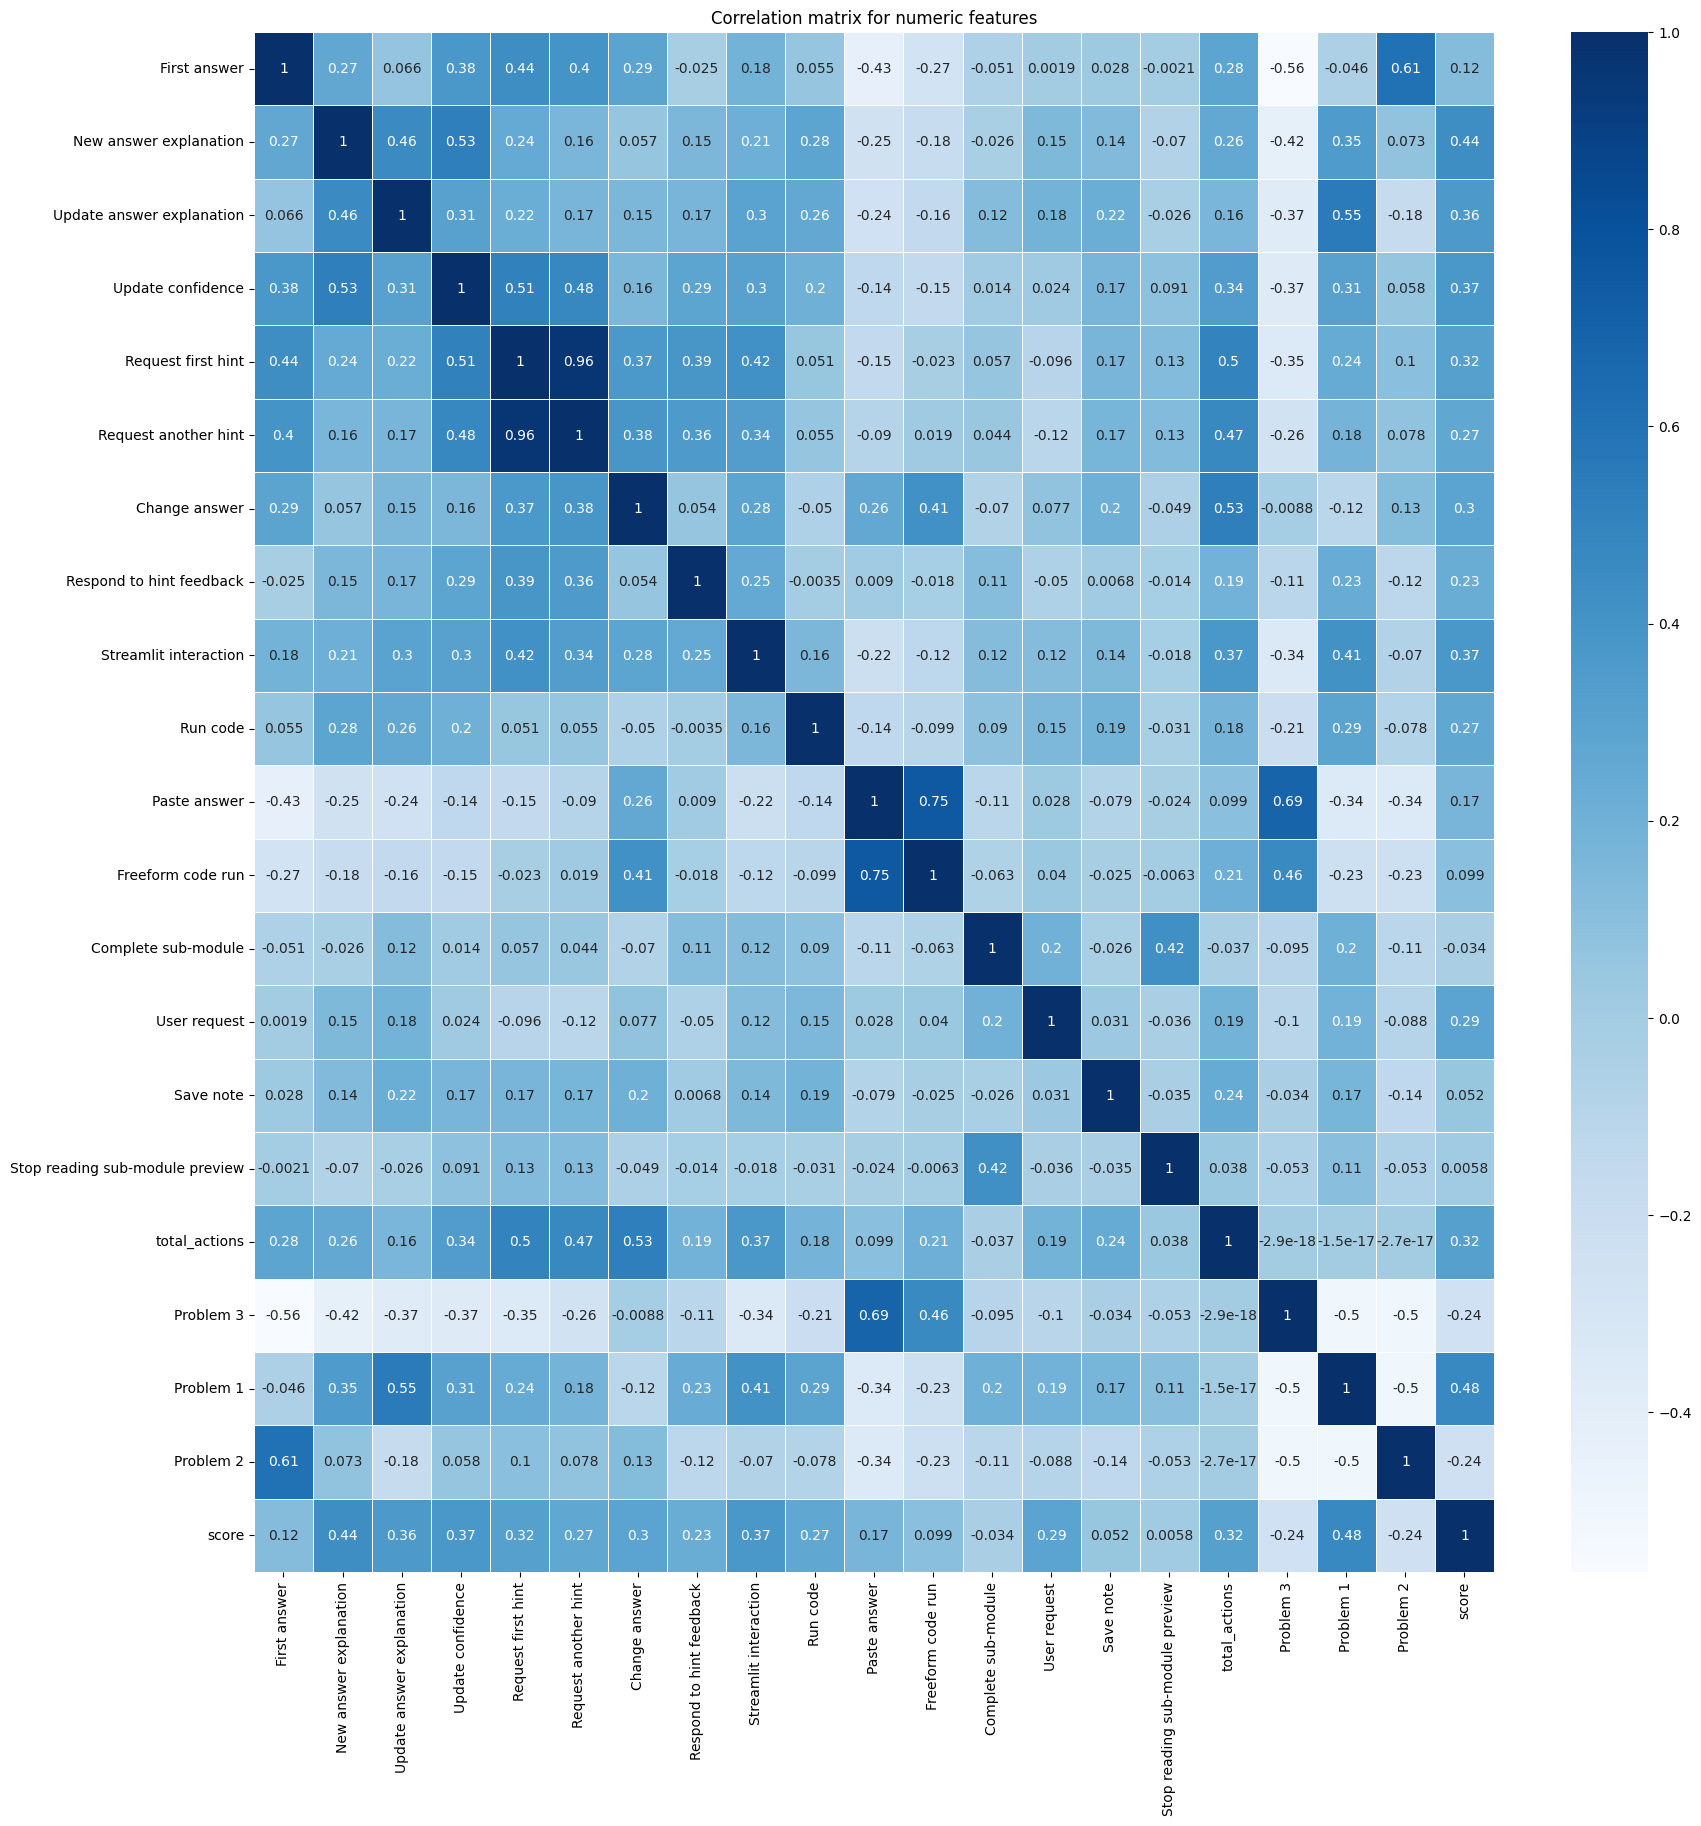

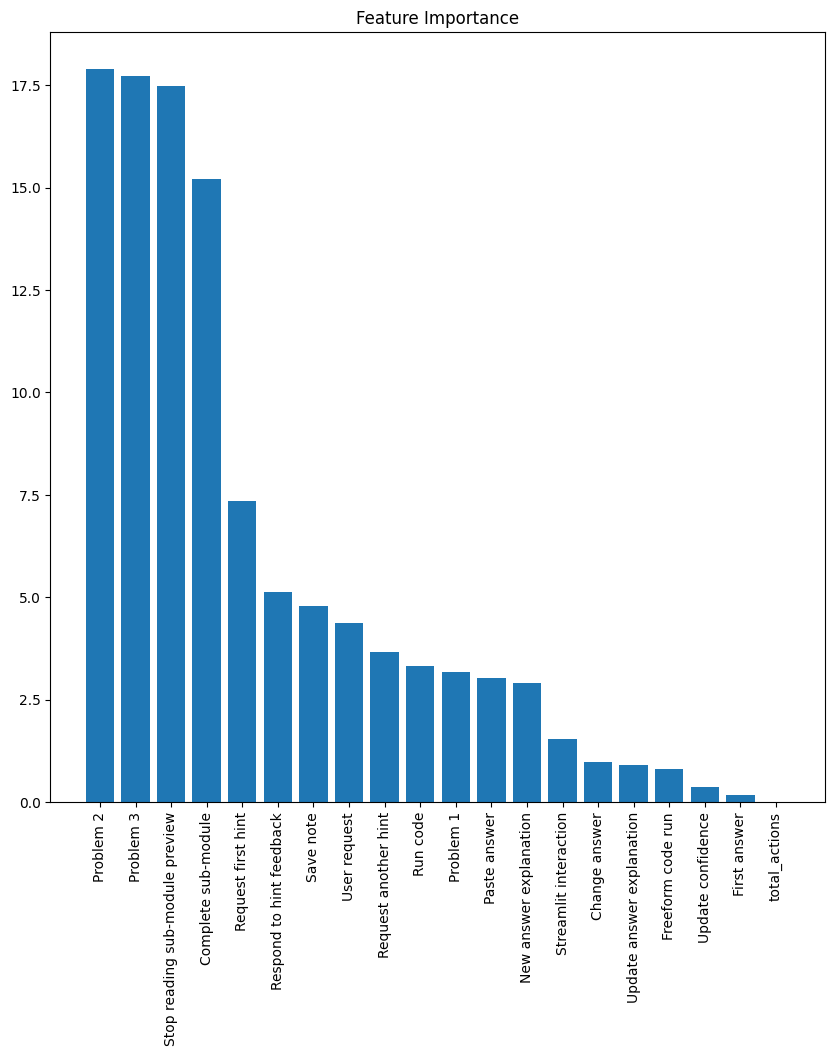

In [246]:
# use sns to plot the correlation matrix colored by the correlation values
import seaborn as sns

# Calculate the correlation coefficient matrix

correlation_matrix = new_df.drop(['username'], axis=1).corr()


plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, cmap='Blues')
plt.title('Correlation matrix for numeric features')



# Get the feature importance from the trained linear regression model
feature_importance = model.coef_

# Create a DataFrame to display the feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': abs(feature_importance)})


# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot the feature importance
plt.figure(figsize=(10, 10))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.show()


## Augmenting the two groups

In [247]:
# augmenting the data from the other xlsx file
File_xlsx = "data/integration_log_group_b.xlsx"
dfb = pd.read_excel(File_xlsx)
dfb = dfb.iloc[:, :-1] 
# get the unique values of the column action
unique_actions = dfb.action.unique()
# peint unique actions with their counts
print(dfb['action'].value_counts())

action
Change answer                      7007
First answer                       2410
Update confidence                  1660
Request another hint               1233
New answer explanation             1131
Streamlit interaction              1113
Update answer explanation          1025
Paste answer                       1016
Request first hint                  874
Auto-save log                       856
Load page                           853
Freeform code run                   817
Load default toolbox page           634
Run code error                      348
Start reading sub-module            313
Run code                            263
Respond to hint feedback            219
Start problem                       129
Submit problem                      124
Complete sub-module                  80
User login                           58
Save note                            34
Stop reading sub-module preview      14
User logout                           3
Name: count, dtype: int64


In [248]:
dfb = dfb.fillna('0')
dfb.iloc[0, 3] = 'Problem 1'
# change the third column name to time
dfb.rename(columns={"Time since session started\n(h:mm:ss)":'time'}, inplace=True)

for i in range(len(dfb)):
    if dfb.iloc[i, 3][:7] != 'Problem':
        dfb.iloc[i, 3] = dfb.iloc[i-1, 3]
dfb['space'].value_counts()

space
Problem 1    7961
Problem 3    7505
Problem 2    6748
Name: count, dtype: int64

In [249]:
action_counts = pd.DataFrame(columns=unique_actions)
for user in dfb.username.unique():
    user_actions = dfb[dfb.username == user].action.value_counts()
    action_counts.loc[user, user_actions.index] = user_actions.values
action_counts = action_counts.fillna(0)
# add the total_actions column to the action_counts df
action_counts['total'] = dfb.groupby('username').count().action
flag = 0
action_counts.head()

File_score_xlsx = "data/Groupb_scores.xlsx"
read_file = pd.read_excel(File_score_xlsx)

# change the first column name to username
read_file.rename(columns={"Participant ID's":'username', 'Problem 1 (Score out of 16)': 'score1',
                         'Problem 2 (Score out of 20)': 'score2', 'Problem 3 (Score out of 18)': 'score3' }, inplace=True)
read_file[:-3]
# use the username as the index
read_file.set_index('username', inplace=True)
# devide first column by 16, second column by 20, third column by 18
read_file['score1'] = read_file['score1'].div(16)
read_file['score2'] = read_file['score2'].div(20)
read_file['score3'] = read_file['score3'].div(18)

read_file.head()
action_counts = action_counts.merge(read_file, left_index=True, right_index=True)
action_counts.head()

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,Freeform code run,Save note,Start reading sub-module,User logout,Complete sub-module,Stop reading sub-module preview,total,score1,score2,score3
b1,1,4,66,3,33,68,39,34,63,373,...,98,0,0,0,0,0,1014,0.8750,0.65,0.833333
b2,3,13,24,3,10,61,80,39,0,248,...,19,10,1,0,0,0,701,0.6875,0.50,0.722222
b3,2,3,5,3,23,49,52,21,38,268,...,43,0,0,0,0,0,599,0.8125,0.45,1.000000
b6,1,7,9,3,35,62,43,12,30,160,...,7,0,0,0,0,0,426,0.6250,0.30,0.277778
b7,1,8,8,3,26,71,58,52,31,179,...,25,3,0,0,0,0,611,0.5000,0.45,0.833333


In [250]:
new_dfb = pd.DataFrame(columns= list(unique_actions)+ [ 'total_actions']+ [p for p in dfb.space.unique()]+ ['username', 'score']) 
for user in dfb.username.unique():
    if user == 'b27':
            continue
    for problem in dfb.space.unique():
        user_problem = dfb[(dfb.username == user) & (dfb.space == problem)].action.value_counts()
        new_dfb.loc[len(new_dfb), user_problem.index] = user_problem.values
        new_dfb.loc[len(new_dfb)-1, str(problem)] = 1
        new_dfb.loc[len(new_dfb)-1, 'username'] = user
        new_dfb.loc[len(new_dfb)-1, 'score'] = action_counts.loc[user, 'score'+str(problem)[-1:]]
        new_dfb.loc[len(new_dfb)-1, 'total_actions'] = action_counts.loc[user, 'total']
new_dfb = new_dfb.fillna(0)


# get insight what features are important
# remove the features that are not important

# Auto-save log                      1018
# Load default toolbox page           942
# Load page                           453
# Run code error                      276
# Start reading sub-module            135
# User login                           53
# User logout                           6
# Start problem                       124
# Submit problem                      111

new_dfb.drop(['Auto-save log', 'Load default toolbox page', 'Load page', 'Run code error', 'Start reading sub-module', 'User login', 'User logout',  'Start problem', 'Submit problem'], axis=1, inplace=True)
# add new colomn "access to GPT" and put it 0
new_dfb['access to GPT'] = 0
new_dfb

,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,Update answer explanation,Run code,Streamlit interaction,Respond to hint feedback,...,Save note,Complete sub-module,Stop reading sub-module preview,total_actions,Problem 1,Problem 2,Problem 3,username,score,access to GPT
0,9,16,8,15,15,140,6,8,34,2,...,0,0,0,1014,1,0,0,b1,0.875000,0
1,11,41,17,17,22,72,6,0,26,0,...,0,0,0,1014,0,1,0,b1,0.650000,0
2,13,11,14,2,26,161,0,0,1,0,...,0,0,0,1014,0,0,1,b1,0.833333,0
3,8,16,46,15,0,38,34,0,43,4,...,3,0,0,701,1,0,0,b2,0.687500,0
4,1,39,24,17,0,115,18,4,16,0,...,4,0,0,701,0,1,0,b2,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,21,37,27,20,20,87,3,0,9,0,...,0,0,0,629,0,1,0,b49,0.400000,0
128,16,13,20,17,31,85,9,0,2,0,...,0,0,0,629,0,0,1,b49,0.472222,0
129,15,16,25,17,20,20,14,0,17,3,...,1,0,0,515,1,0,0,b51,0.375000,0
130,19,48,22,20,22,52,6,0,3,2,...,0,0,0,515,0,1,0,b51,0.400000,0


In [251]:
# attatch new_dfb to the end of new_df
new_df['access to GPT'] = 1
new_df = pd.concat([new_df, new_dfb], ignore_index=True)
new_df.fillna(0, inplace=True)
new_df

,First answer,New answer explanation,Update answer explanation,Update confidence,Request first hint,Request another hint,Change answer,Respond to hint feedback,Streamlit interaction,Run code,...,User request,Save note,Stop reading sub-module preview,total_actions,Problem 3,Problem 1,Problem 2,username,score,access to GPT
0,0,0,0,21,18,36,41,20,4,0,...,0.0,0,0,539,1,0,0,a1,0.583333,1
1,16,11,14,16,16,26,22,22,8,1,...,0.0,0,0,539,0,1,0,a1,0.687500,1
2,25,8,3,23,16,19,44,13,12,0,...,0.0,0,0,539,0,0,1,a1,0.450000,1
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,202,1,0,0,a2,0.000000,1
4,11,11,6,11,13,26,20,12,31,2,...,0.0,0,0,202,0,1,0,a2,0.437500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,37,20,3,27,21,20,87,0,9,0,...,0.0,0,0,629,0,0,1,b49,0.400000,0
263,13,17,9,20,16,31,85,0,2,0,...,0.0,0,0,629,1,0,0,b49,0.472222,0
264,16,17,14,25,15,20,20,3,17,0,...,0.0,1,0,515,0,1,0,b51,0.375000,0
265,48,20,6,22,19,22,52,2,3,0,...,0.0,0,0,515,0,0,1,b51,0.400000,0


In [252]:
end_cols = ['Problem 1', 'Problem 2', 'Problem 3', 'username', 'score']
new_df = new_df[[c for c in new_df if c not in end_cols] + [c for c in end_cols if c in new_df]]
new_df.head()

,First answer,New answer explanation,Update answer explanation,Update confidence,Request first hint,Request another hint,Change answer,Respond to hint feedback,Streamlit interaction,Run code,...,User request,Save note,Stop reading sub-module preview,total_actions,access to GPT,Problem 1,Problem 2,Problem 3,username,score
0,0,0,0,21,18,36,41,20,4,0,...,0.0,0,0,539,1,0,0,1,a1,0.583333
1,16,11,14,16,16,26,22,22,8,1,...,0.0,0,0,539,1,1,0,0,a1,0.687500
2,25,8,3,23,16,19,44,13,12,0,...,0.0,0,0,539,1,0,1,0,a1,0.450000
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,202,1,0,0,1,a2,0.000000
4,11,11,6,11,13,26,20,12,31,2,...,0.0,0,0,202,1,1,0,0,a2,0.437500


previous length of data:  267
IQR:  0.3875
current length of data:  267


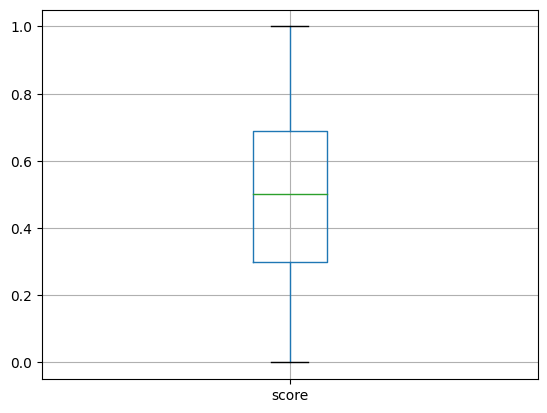

In [253]:
# apply outlier detection with IQR
# remove the outliers in new_df
# find the outliers in score column
Q1 = new_df['score'].quantile(0.25)
Q3 = new_df['score'].quantile(0.75)
IQR = Q3 - Q1
print('previous length of data: ' ,len(new_df))
print("IQR: ", IQR)
# plot the boxplot to see the outliers
new_df.boxplot(column=['score'])

# remove the outliers in score column
new_df = new_df[~((new_df['score'] < (Q1 - 1.5 * IQR)) |(new_df['score'] > (Q3 + 1.5 * IQR)))]
print('current length of data: ' ,len(new_df))
plt.show()

RMSE:  0.03494529809775213
R2:  0.5188243958917904
RMSE normalize:  0.04256004592469925
R2 normalize:  0.4139739271530891


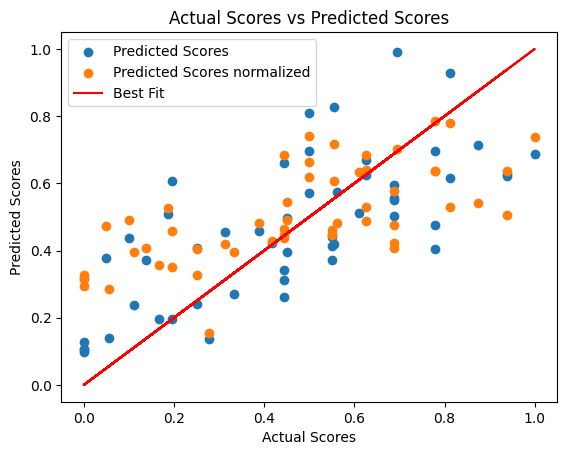

In [254]:
# Split the data into training and testing sets
X = new_df.drop(['username', 'score'], axis=1)
y = new_df['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the scores for the test set
y_pred = model.predict(X_test)

# norrmalize the features
for col in X.columns:
    # X[col] = X[col].div(X[col].sum())
    X[col] = X[col].div(new_df['total_actions'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the scores for the test set
y_pred_norm = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R2: ', r2)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred_norm)
r2 = r2_score(y_test, y_pred_norm)
print('RMSE normalize: ', rmse)
print('R2 normalize: ', r2)


# plot the predicted and actual scores
plt.scatter(y_test, y_pred, label='Predicted Scores')
plt.scatter(y_test, y_pred_norm, label='Predicted Scores normalized')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual Scores vs Predicted Scores')
# plot the line of best fit
plt.plot(y_test, y_test, color='red', label='Best Fit')
plt.legend()
plt.show()



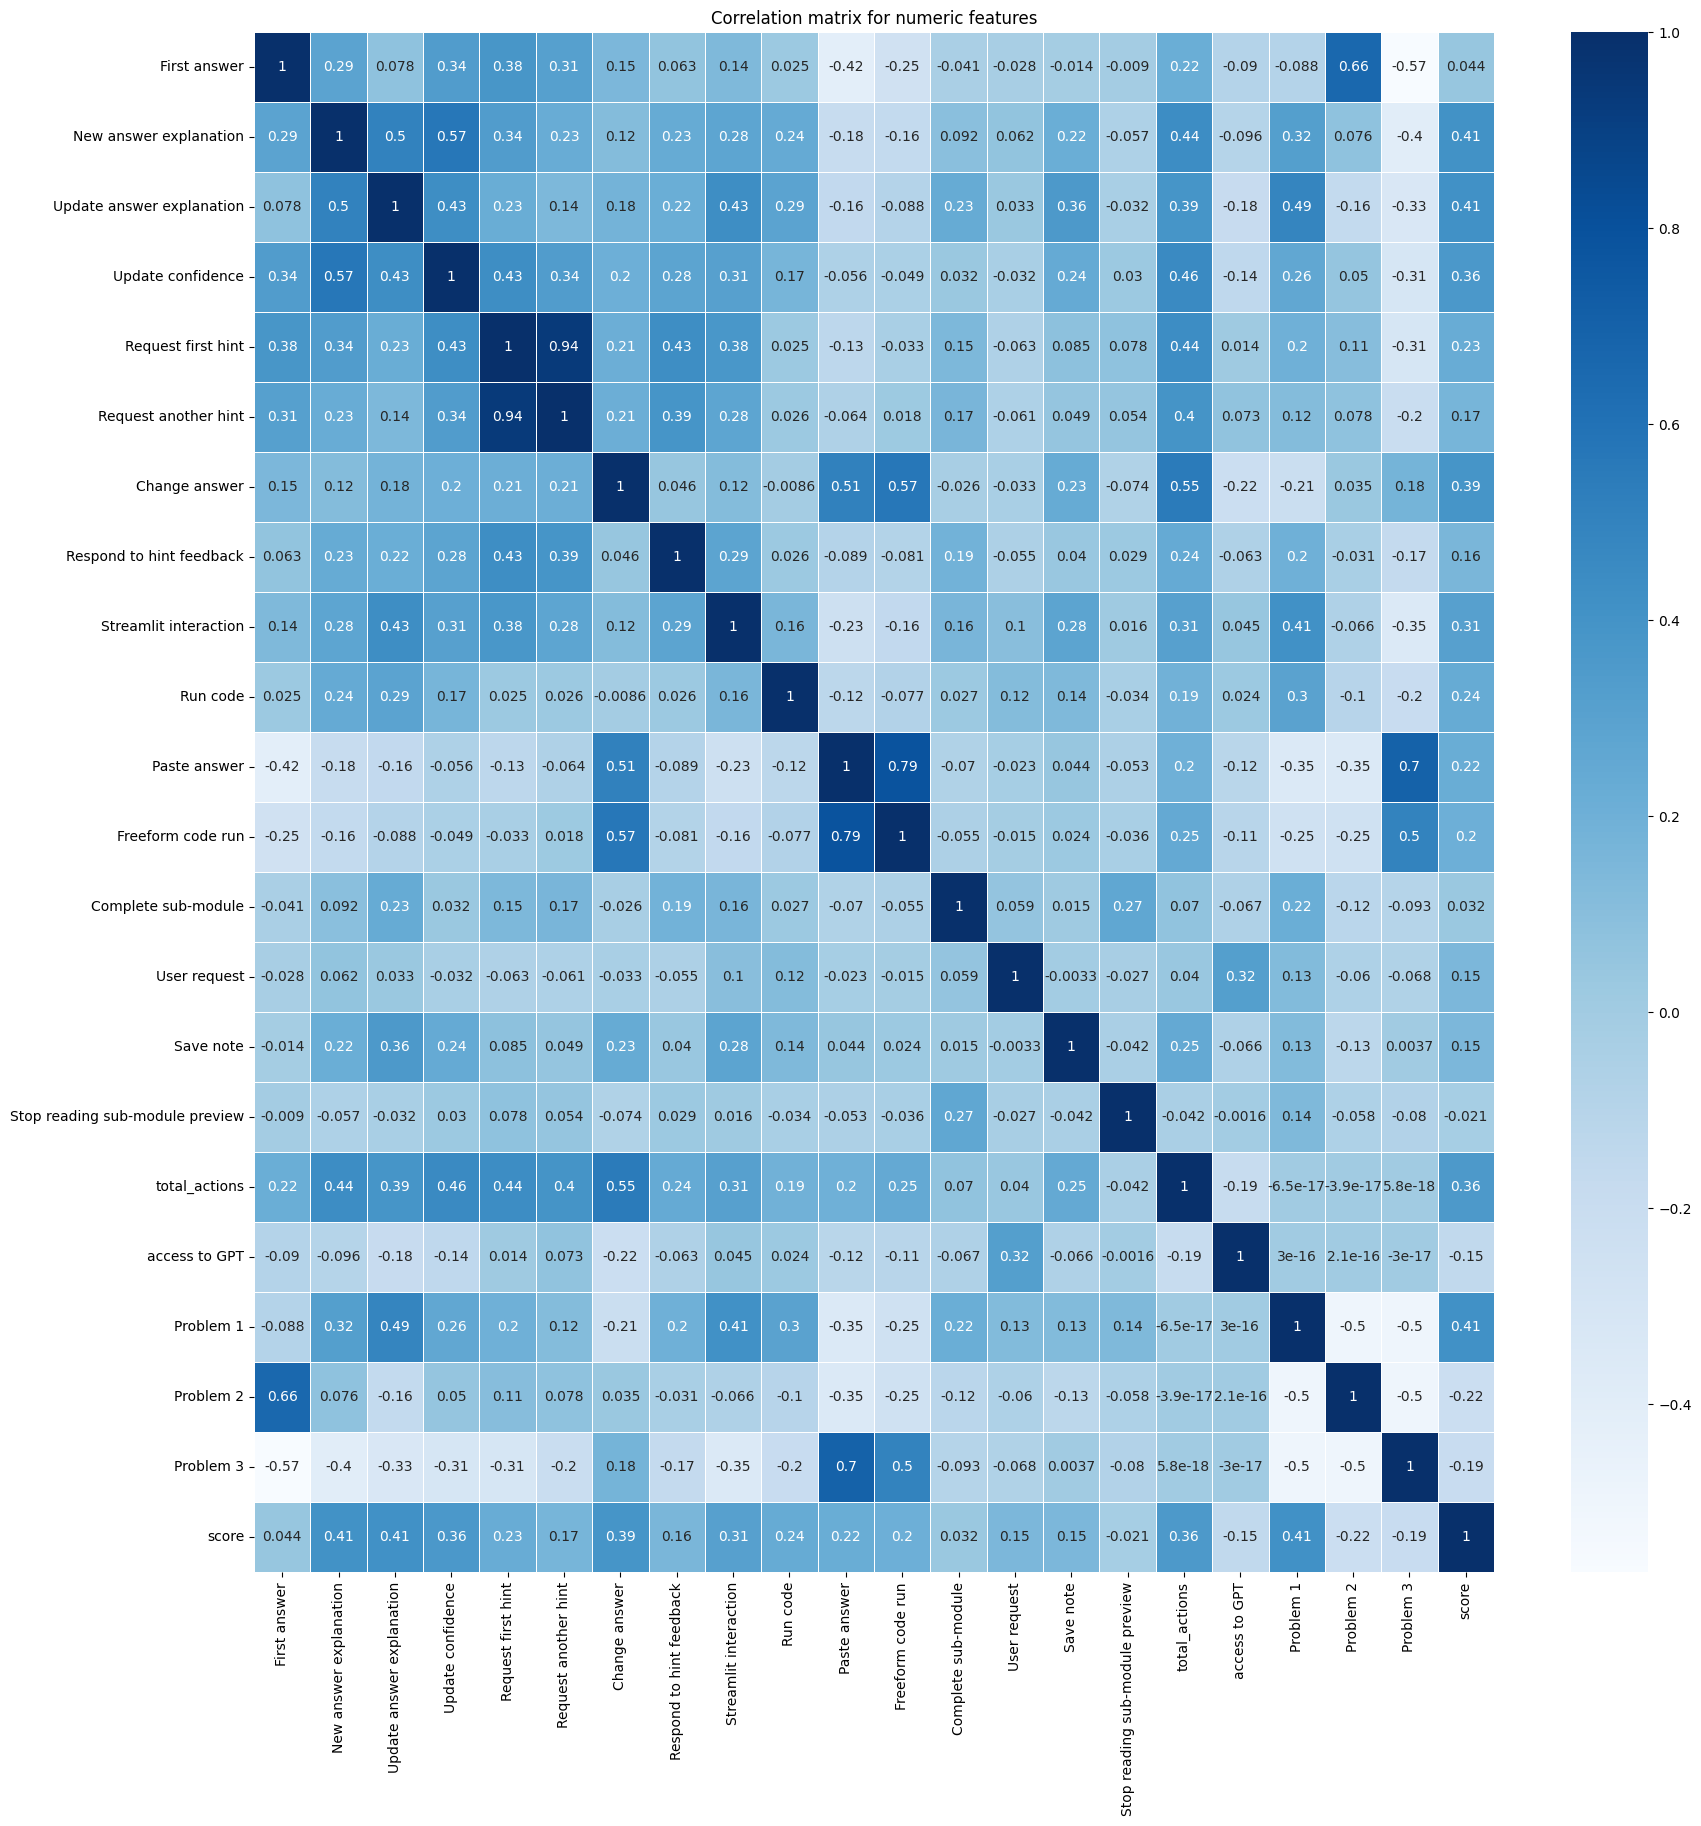

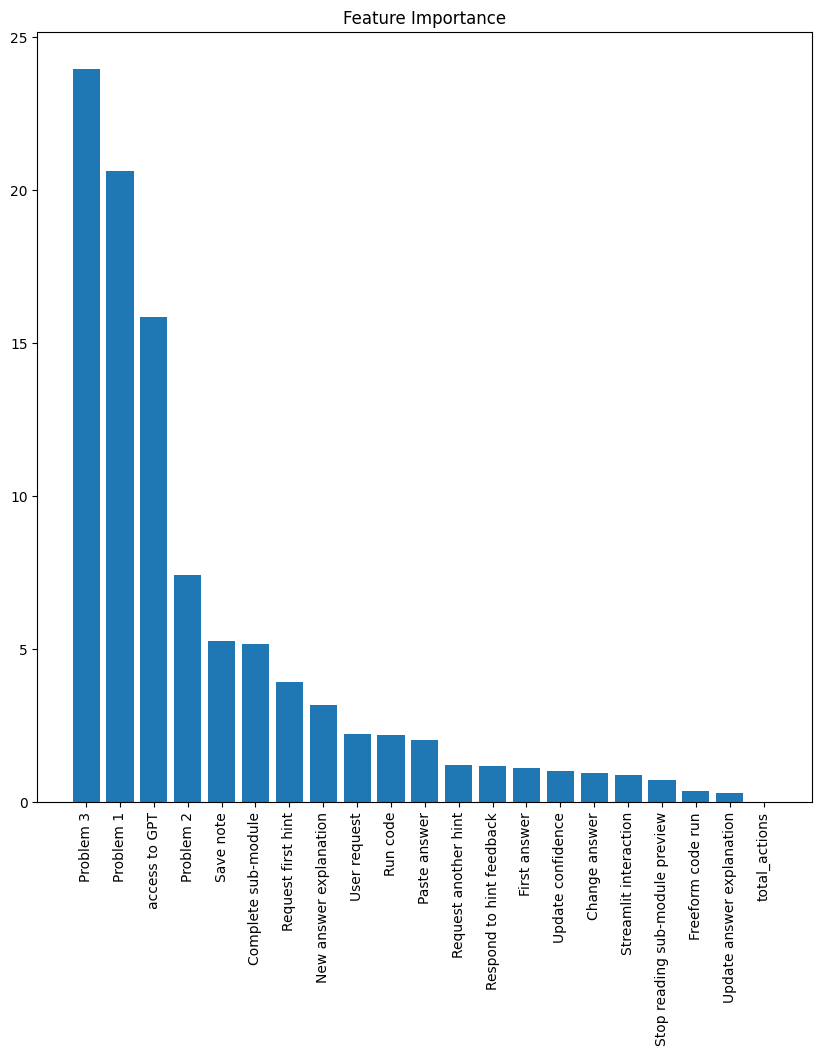

In [255]:
# use sns to plot the correlation matrix colored by the correlation values
import seaborn as sns

# Calculate the correlation coefficient matrix

correlation_matrix = new_df.drop(['username'], axis=1).corr()


plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, cmap='Blues')
plt.title('Correlation matrix for numeric features')



# Get the feature importance from the trained linear regression model
feature_importance = model.coef_

# Create a DataFrame to display the feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': abs(feature_importance)})


# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot the feature importance
plt.figure(figsize=(10, 10))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.show()


In [308]:
# compute 3 seperate models for each problem
# create 3 df for each problem and drop problem 2 and 3 from each df
df1 = new_df[new_df['Problem 1'] == 1].drop(['Problem 1', 'Problem 2', 'Problem 3'], axis=1)
df2 = new_df[new_df['Problem 2'] == 1].drop(['Problem 1', 'Problem 2', 'Problem 3'], axis=1)
df3 = new_df[new_df['Problem 3'] == 1].drop(['Problem 1', 'Problem 2', 'Problem 3'], axis=1)

In [331]:
def linreg_train_plot(dfin, name='linreg'):
    # Split the data into training and testing sets
    X = dfin.drop(['username', 'score'], axis=1)
    y = dfin['score']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a linear regression model
    if name == 'linreg':
        model = LinearRegression()
    elif name == 'ridge':
        model = Ridge(alpha=1)
    elif name == 'lasso':
        model = Lasso(alpha = 1)
    else:
        print('wrong name')
        return
    model.fit(X_train, y_train)

    # Predict the scores for the test set
    y_pred = model.predict(X_test)

    # norrmalize the features
   
    for col in X.columns:
        # X[col] = X[col].div(X[col].sum())
        X[col] = X[col].div(dfin['total_actions'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict the scores for the test set
    y_pred_norm = model.predict(X_test)

    # Evaluate the model
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('RMSE: ', rmse)
    print('R2: ', r2)

    # Evaluate the model
    rmse = mean_squared_error(y_test, y_pred_norm)
    r2 = r2_score(y_test, y_pred_norm)
    print('RMSE normalize: ', rmse)
    print('R2 normalize: ', r2)


    # plot the predicted and actual scores
    plt.scatter(y_test, y_pred, label='Predicted Scores')
    plt.scatter(y_test, y_pred_norm, label='Predicted Scores normalized')
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.title('Actual Scores vs Predicted Scores')
    # plot the line of best fit
    plt.plot(y_test, y_test, color='red', label='Best Fit')
    plt.legend()
    plt.show()
    return model

problem 1
RMSE:  0.03696208371859445
R2:  -0.23770006942070965
RMSE normalize:  0.03317140173443083
R2 normalize:  -0.11076655044837747


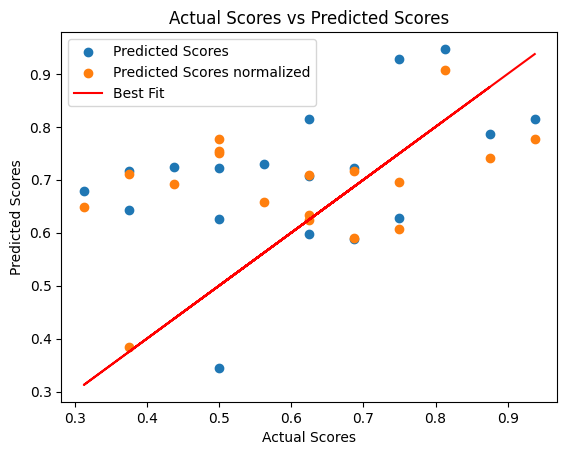

problem 2
RMSE:  0.03145020672120338
R2:  0.02605811444015327
RMSE normalize:  0.03116936666304319
R2 normalize:  0.034755096886404546


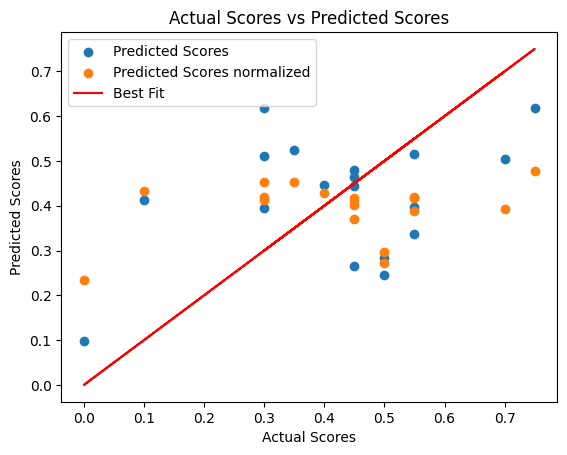

problem 3
RMSE:  0.5799545933305956
R2:  -4.46351498794989
RMSE normalize:  0.38051607621899725
R2 normalize:  -2.584686300420924


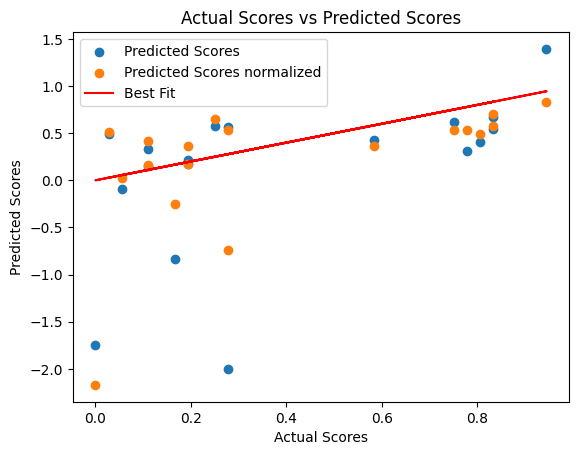

In [310]:
print('problem 1')
model1 = linreg_train_plot(df1)
print('problem 2')
model2= linreg_train_plot(df2)
print('problem 3')
model3 = linreg_train_plot(df3)

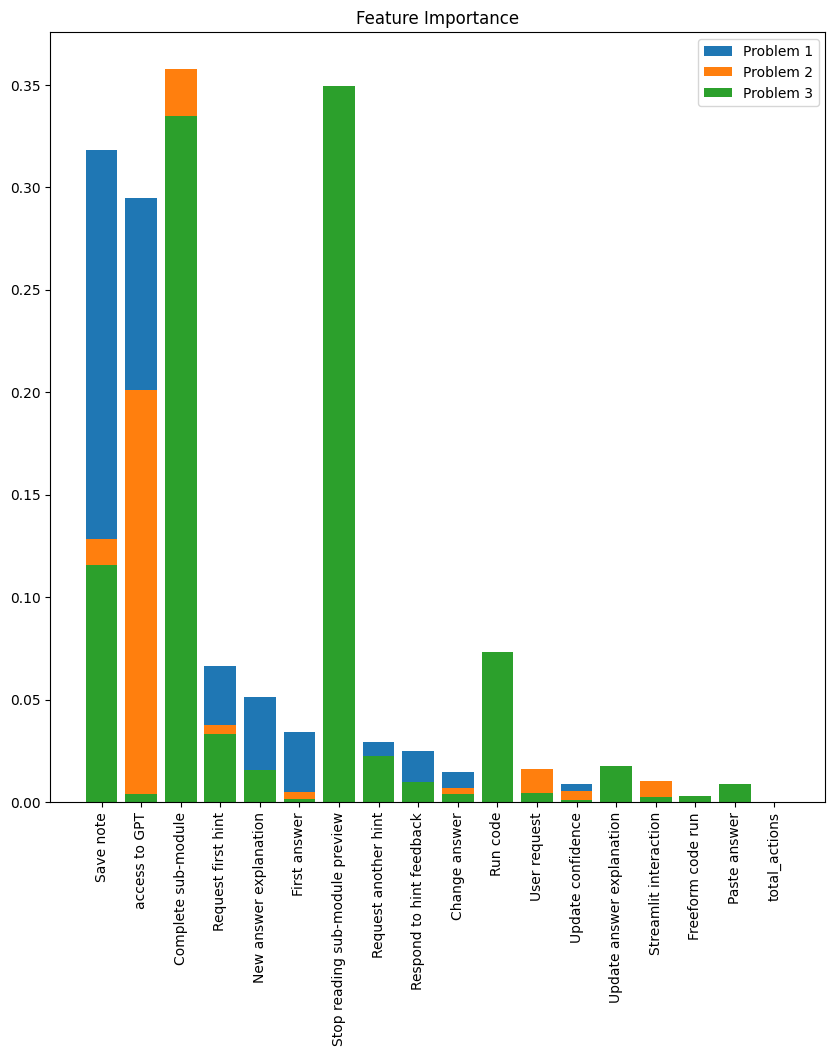

In [311]:
# Get the feature importance from the trained linear regression models
feature_importance1 = model1.coef_
feature_importance2 = model2.coef_
feature_importance3 = model3.coef_

# Create a DataFrame to display the feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns[:-3], 'Importance1': abs(feature_importance1), 'Importance2': abs(feature_importance2), 'Importance3': abs(feature_importance3)})

# normalize the feature_importance_df
feature_importance_df['Importance1'] = feature_importance_df['Importance1'].div(feature_importance_df['Importance1'].sum())
feature_importance_df['Importance2'] = feature_importance_df['Importance2'].div(feature_importance_df['Importance2'].sum())
feature_importance_df['Importance3'] = feature_importance_df['Importance3'].div(feature_importance_df['Importance3'].sum())

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance1', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 10))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance1'], label='Problem 1')
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance2'], label='Problem 2')
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance3'], label='Problem 3')
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.legend()
plt.show()



In [312]:
from sklearn.tree import DecisionTreeRegressor

In [313]:
def dt_train_plot(dfin):
    # Split the data into training and testing sets
    X = dfin.drop(['username', 'score'], axis=1)
    y = dfin['score']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Create the decision tree regressor
    tree = DecisionTreeRegressor(random_state=42)
    tree.fit(X_train, y_train)

    # Predict the scores for the test set
    y_pred = tree.predict(X_test)


    # norrmalize the features
    for col in X.columns:
        # X[col] = X[col].div(X[col].sum())
        X[col] = X[col].div(dfin['total_actions'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    tree.fit(X_train, y_train)
    y_pred_norm = tree.predict(X_test)

    # Evaluate the model
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('RMSE: ', rmse)
    print('R2: ', r2)

    # Evaluate the model
    rmse = mean_squared_error(y_test, y_pred_norm)
    r2 = r2_score(y_test, y_pred_norm)
    print('RMSE normalize: ', rmse)
    print('R2 normalize: ', r2)


    # plot the predicted and actual scores
    plt.scatter(y_test, y_pred, label='Predicted Scores')
    plt.scatter(y_test, y_pred_norm, label='Predicted Scores normalized')
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.title('Actual Scores vs Predicted Scores')
    # plot the line of best fit
    plt.plot(y_test, y_test, color='red', label='Best Fit')
    plt.legend()
    plt.show()
    return tree

    

problem 1
RMSE:  0.0740017361111111
R2:  -1.4779975777149779
RMSE normalize:  0.04383680555555555
R2 normalize:  -0.46790472345579337


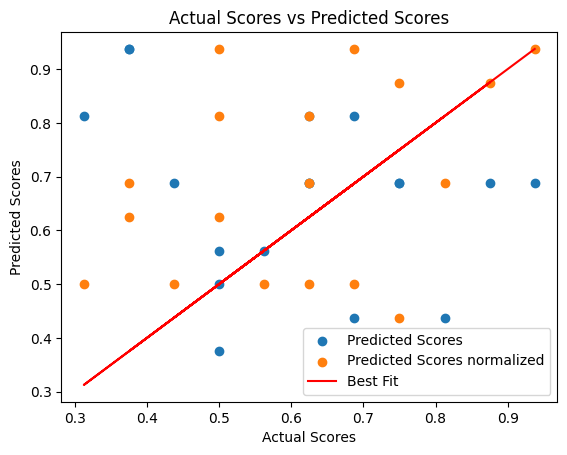

problem 2
RMSE:  0.04847222222222222
R2:  -0.5010752688172042
RMSE normalize:  0.038888888888888896
R2 normalize:  -0.20430107526881747


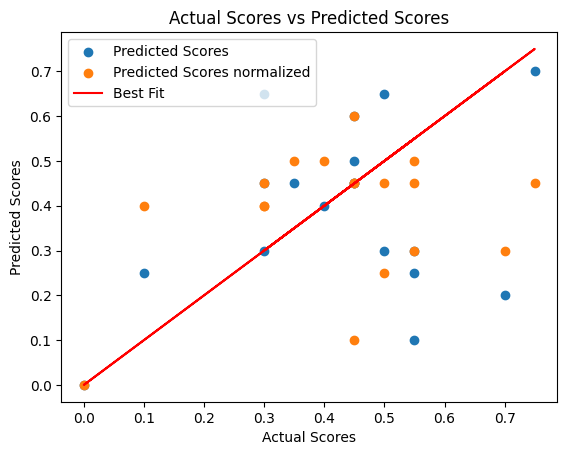

problem 3
RMSE:  0.07617455418381346
R2:  0.2823906849437998
RMSE normalize:  0.0736025377229081
R2 normalize:  0.30662059991474633


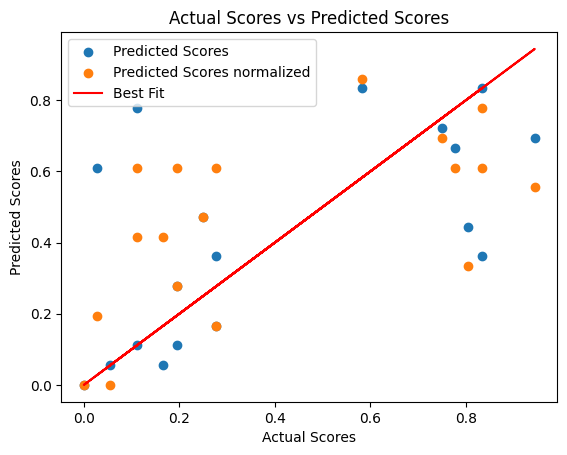

All
RMSE:  0.07597736625514404
R2:  -0.04616234791029772
RMSE normalize:  0.07665223479652494
R2 normalize:  -0.05545487925984349


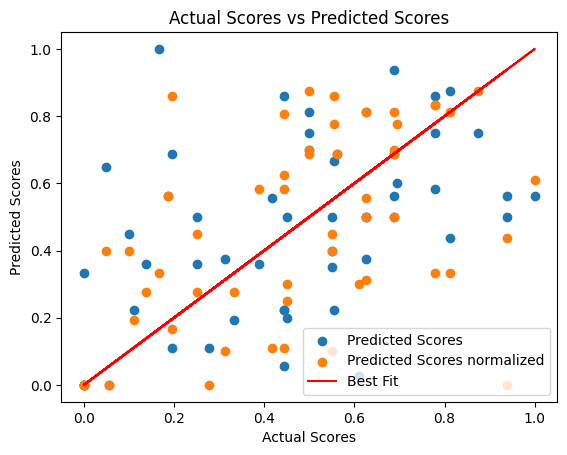

In [315]:
print('problem 1')
tree1 = dt_train_plot(df1)
print('problem 2')
tree2= dt_train_plot(df2)
print('problem 3')
tree3 = dt_train_plot(df3)
print('All')
tree3 = dt_train_plot(new_df)

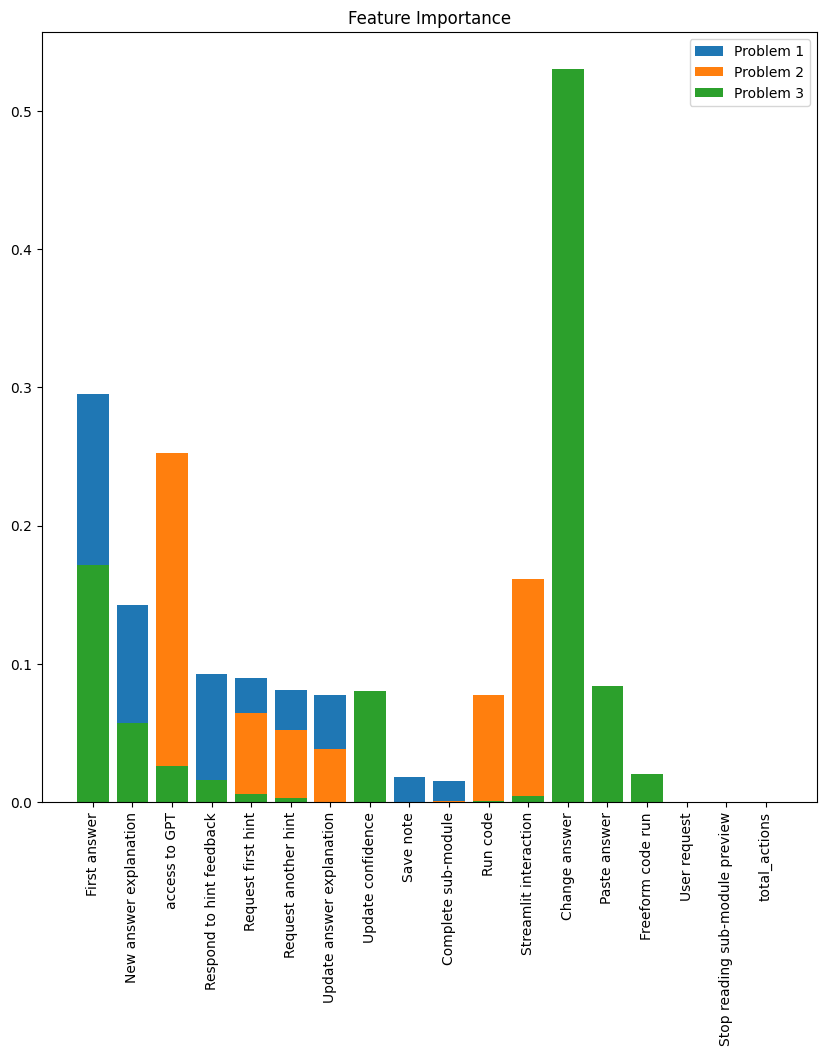

In [266]:
# Get the feature importance from the trained linear regression models
feature_importance1 = tree1.feature_importances_
feature_importance2 = tree2.feature_importances_
feature_importance3 = tree3.feature_importances_

# Create a DataFrame to display the feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns[:-3], 'Importance1': abs(feature_importance1), 'Importance2': abs(feature_importance2), 'Importance3': abs(feature_importance3)})

# normalize the feature_importance_df
feature_importance_df['Importance1'] = feature_importance_df['Importance1'].div(feature_importance_df['Importance1'].sum())
feature_importance_df['Importance2'] = feature_importance_df['Importance2'].div(feature_importance_df['Importance2'].sum())
feature_importance_df['Importance3'] = feature_importance_df['Importance3'].div(feature_importance_df['Importance3'].sum())

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance1', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 10))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance1'], label='Problem 1')
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance2'], label='Problem 2')
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance3'], label='Problem 3')
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.legend()
plt.show()

Ridge model
problem 1
RMSE:  0.036701539636347
R2:  -0.22897557674491953
RMSE normalize:  0.03317140173443083
R2 normalize:  -0.11076655044837747


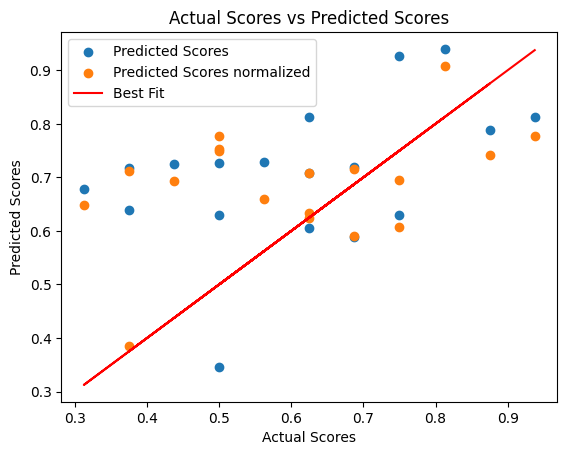

problem 2
RMSE:  0.02854370583124075
R2:  0.11606588393577044
RMSE normalize:  0.03116936666304319
R2 normalize:  0.034755096886404546


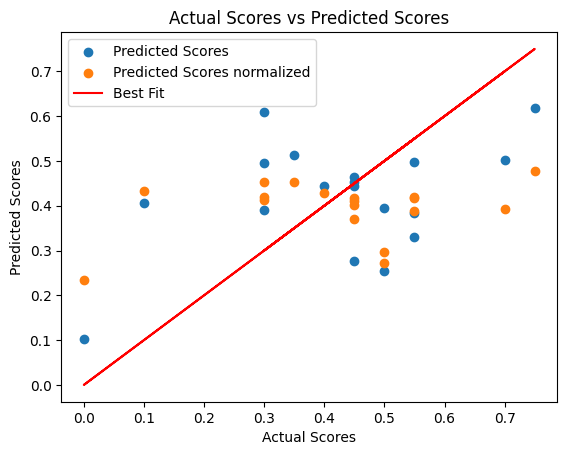

problem 3
RMSE:  0.167383005459546
R2:  -0.5768468248600098
RMSE normalize:  0.38051607621899725
R2 normalize:  -2.584686300420924


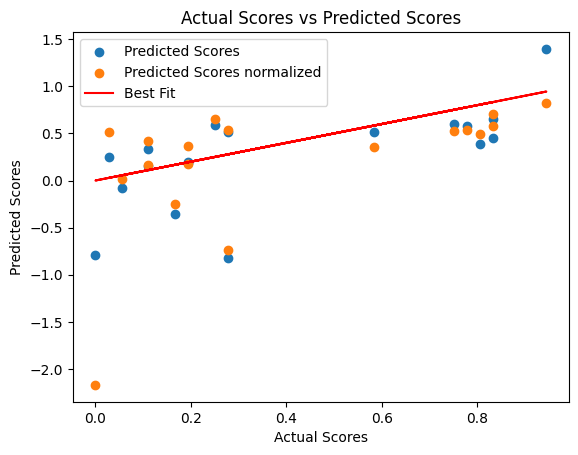

All
RMSE:  0.03484747214566846
R2:  0.5201714000426678
RMSE normalize:  0.04256004592469925
R2 normalize:  0.4139739271530891


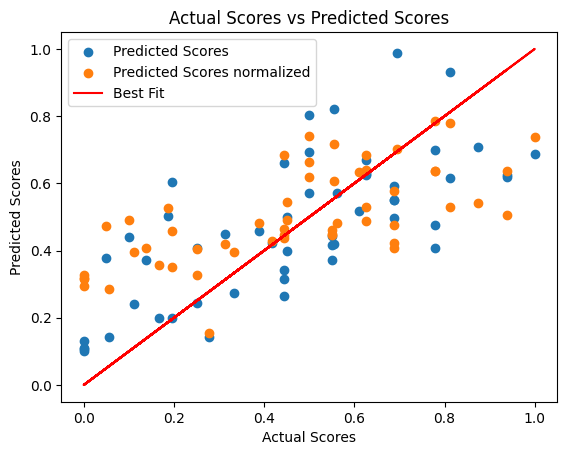

In [333]:
print('Ridge model')
print('problem 1')
model1 = linreg_train_plot(df1, 'ridge')
print('problem 2')
model2= linreg_train_plot(df2, 'ridge')
print('problem 3')
model3 = linreg_train_plot(df3, 'ridge')
print('All')
model3 = linreg_train_plot(new_df, 'ridge')

Lasso model
problem 1
RMSE:  0.026206071245302356
R2:  0.12247219484442529
RMSE normalize:  0.03317140173443083
R2 normalize:  -0.11076655044837747


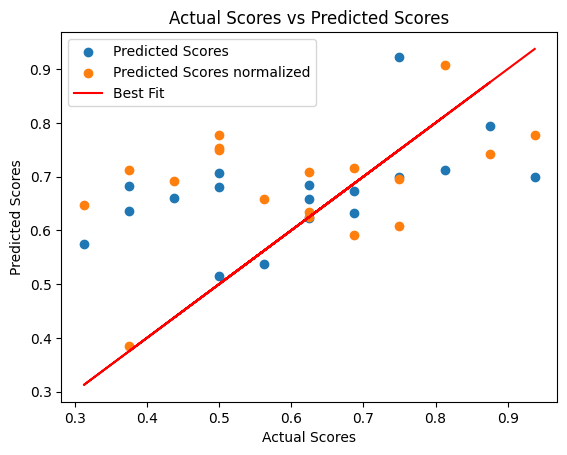

problem 2
RMSE:  0.02388151305120577
R2:  0.26044346680136987
RMSE normalize:  0.03116936666304319
R2 normalize:  0.034755096886404546


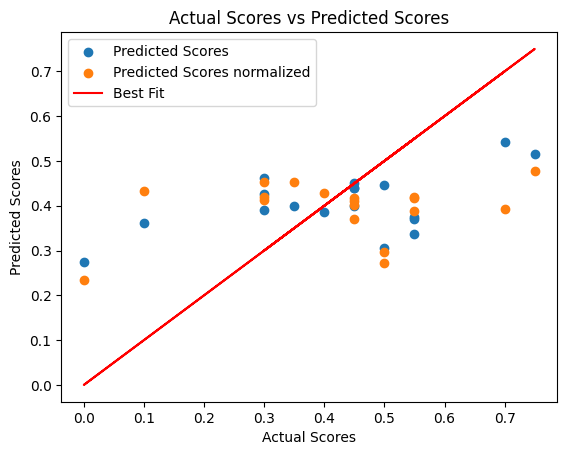

problem 3
RMSE:  0.05599868493170695
R2:  0.4724592960410231
RMSE normalize:  0.38051607621899725
R2 normalize:  -2.584686300420924


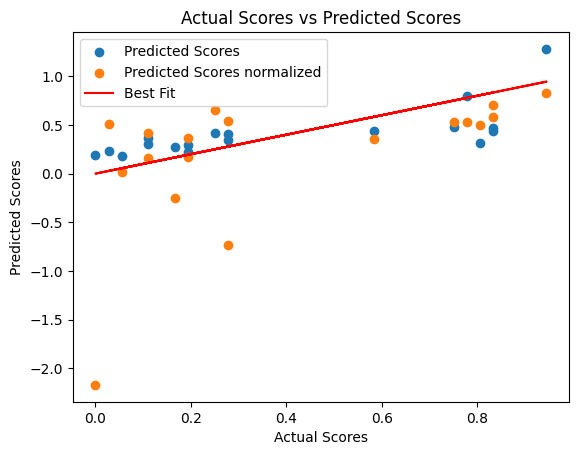

All
RMSE:  0.07462121792361297
R2:  -0.027489006196071974
RMSE normalize:  0.04256004592469925
R2 normalize:  0.4139739271530891


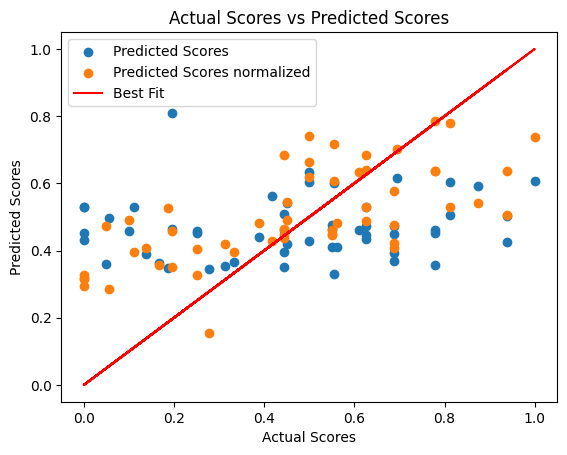

In [332]:
print('Lasso model')
print('problem 1')
model1 = linreg_train_plot(df1, 'lasso')
print('problem 2')
model2= linreg_train_plot(df2, 'lasso')
print('problem 3')
model3 = linreg_train_plot(df3, 'lasso')
print('All')
model3 = linreg_train_plot(new_df, 'lasso')

In [ ]:
## Classification problem


In [ ]:
## Feature Engineering

In [ ]:
## HMM and ExAI